<a href="https://colab.research.google.com/github/chillax79/Logistics-Performance-Diagnostic-Central-Asia-Region/blob/main/Analytics_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistics Performance Diagnostic: Central Asia Region

## 1. Project Background & Objective
**Objective:** This analysis aims to identify the root causes behind the high late delivery rate (67%) specifically within the Central Asia region.

**Scope of Work:**

* **Shipping Mode Efficiency:** Evaluate SLA compliance across shipping classes.
* **Regional Hotspots:** Identify underperforming states using Pareto (80/20) Principle.
* **Root Cause Validation:** Distinguish between Capacity Overload and Operational Inefficiency using Correlation.
* **Temporal Trends:** Identify seasonal bottlenecks.



##2. Data Setup & Foundation
>**Data Setup & Cleaning**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

sns.set_theme(style="whitegrid")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = 'DataCoSupplyChainDataset.csv'
df = pd.read_csv(file_path, encoding='latin1')

print(f"Dataset loaded successfully with {df.shape[0]} rows.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully with 180519 rows.


In [ ]:
# --- STEP 0: Data Setup & Foundation ---

# 1. Define the specific columns required for logistics and time-series analysis
# This reduces the dataframe from 53 columns down to 10 for better performance
essential_cols = [
    'Order Region',
    'Order State',
    'Order City',
    'Shipping Mode',
    'Category Name',
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Late_delivery_risk',
    'Delivery Status',
    'order date (DateOrders)'
]

# 2. Filter for Central Asia region and create a deep copy with essential columns
df_central_asia = df[df['Order Region'] == 'Central Asia'][essential_cols].copy()

# 3. Convert 'order date (DateOrders)' to datetime objects for temporal analysis
# This is required for Segment 3 (Trend Analysis)
# Standardize the target variable 'Date Orders'
df_central_asia['Date Orders'] = pd.to_datetime(df_central_asia['order date (DateOrders)'])

# 4. Standardize the target variable 'Late Delivery'
# 1 indicates a late shipment, 0 indicates on-time
df_central_asia['Late Delivery'] = df_central_asia['Late_delivery_risk']

# 5. Aggregate data by State and Shipping Mode to create a base for Pareto and Correlation analysis
df_late_rate = df_central_asia.groupby(['Order State', 'Shipping Mode']).agg(
    Total_Orders=('Late Delivery', 'count'),
    Late_Orders=('Late Delivery', 'sum')
).reset_index()
df_late_rate['Total Orders'] = df_late_rate['Total_Orders']

# 6. Calculate the Late Delivery Rate as a percentage
df_late_rate['Late_Rate_Percentage'] = (df_late_rate['Late_Orders'] / df_late_rate['Total_Orders']) * 100

# Final check of the foundation data
print(f"Foundation data ready. Observations: {df_central_asia.shape[0]} | Selected Columns: {df_central_asia.shape[1]}")
df_central_asia.info()


Foundation data ready. Observations: 553 | Selected Columns: 12
<class 'pandas.core.frame.DataFrame'>
Index: 553 entries, 253 to 177411
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Order Region                   553 non-null    object        
 1   Order State                    553 non-null    object        
 2   Order City                     553 non-null    object        
 3   Shipping Mode                  553 non-null    object        
 4   Category Name                  553 non-null    object        
 5   Days for shipping (real)       553 non-null    int64         
 6   Days for shipment (scheduled)  553 non-null    int64         
 7   Late_delivery_risk             553 non-null    int64         
 8   Delivery Status                553 non-null    object        
 9   order date (DateOrders)        553 non-null    object        
 10  Date Orders           

>**State-level Aggregation (Pareto Foundation)**

In [ ]:
# --- STEP 1: Regional Hotspot Analysis using Pareto Principle ---

# 1. Summarize total orders by State to identify high-volume hubs
state_pareto = df_late_rate.groupby('Order State')['Total Orders'].sum().reset_index()
state_pareto = state_pareto.sort_values(by='Total Orders', ascending=False)

# 2. Calculate Cumulative metrics to identify the 80/20 distribution
total_regional_orders = state_pareto['Total Orders'].sum()
state_pareto['Cumulative_Sum'] = state_pareto['Total Orders'].cumsum()
state_pareto['Cumulative_Percentage'] = (state_pareto['Cumulative_Sum'] / total_regional_orders) * 100

# 3. Defining segments: "The Vital Few" (Key Accounts) vs "The Useful Many" (Long-tail)
# We chose a threshold of >= 23 orders based on the 80% cutoff point (approx. 85% cumulative)
state_pareto['Segment'] = state_pareto['Cumulative_Percentage'].apply(
    lambda x: 'The Vital Few (Key Accounts)' if x <= 85 else 'The Useful Many (Long-tail)'
)

# 4. Create a list of Key Account states for further diagnostic filtering
key_states_list = state_pareto[state_pareto['Segment'] == 'The Vital Few (Key Accounts)']['Order State'].tolist()

# 5. Aggregate performance data for these priority segments only
key_states_performance = df_late_rate[df_late_rate['Order State'].isin(key_states_list)].groupby('Order State').agg({
    'Total Orders': 'sum',
    'Late_Rate_Percentage': 'mean'
}).reset_index()

# Display the segmented Pareto table
print(f"Segmentation Complete: {len(key_states_list)} states identified as Key Accounts.")
state_pareto.head(10)

Segmentation Complete: 12 states identified as Key Accounts.


,Order State,Total Orders,Cumulative_Sum,Cumulative_Percentage,Segment
5,Bishkek,89,89,16.094033,The Vital Few (Key Accounts)
8,Karagandá,63,152,27.486438,The Vital Few (Key Accounts)
4,Astaná,52,204,36.889693,The Vital Few (Key Accounts)
17,Pavlodar,44,248,44.846293,The Vital Few (Key Accounts)
6,Ciudad de Almatý,43,291,52.622061,The Vital Few (Key Accounts)
15,Namangán,38,329,59.493671,The Vital Few (Key Accounts)
12,Kostanái,26,355,64.195298,The Vital Few (Key Accounts)
3,Asjabad,25,380,68.716094,The Vital Few (Key Accounts)
18,Surjandarín,24,404,73.056058,The Vital Few (Key Accounts)
2,Andiján,23,427,77.215190,The Vital Few (Key Accounts)


## 3. Analysis

## Segment 1: Shipping Mode & Category Analysis
> **Analysis Note:**
> * **First Class Systemic Failure:** 100% failure rate for First Class. First Class shipments have a median of 2 days, consistently missing the 0-1 day requirement
> * **Misaligned Priorities:** Electronics are prioritized (2-5 days), while others hit a 6-day delay cap.
> * **Standard Class Anomalies:** "Over-servicing" of Standard Class (delivered in 0-1 days) suggests misallocated resources.

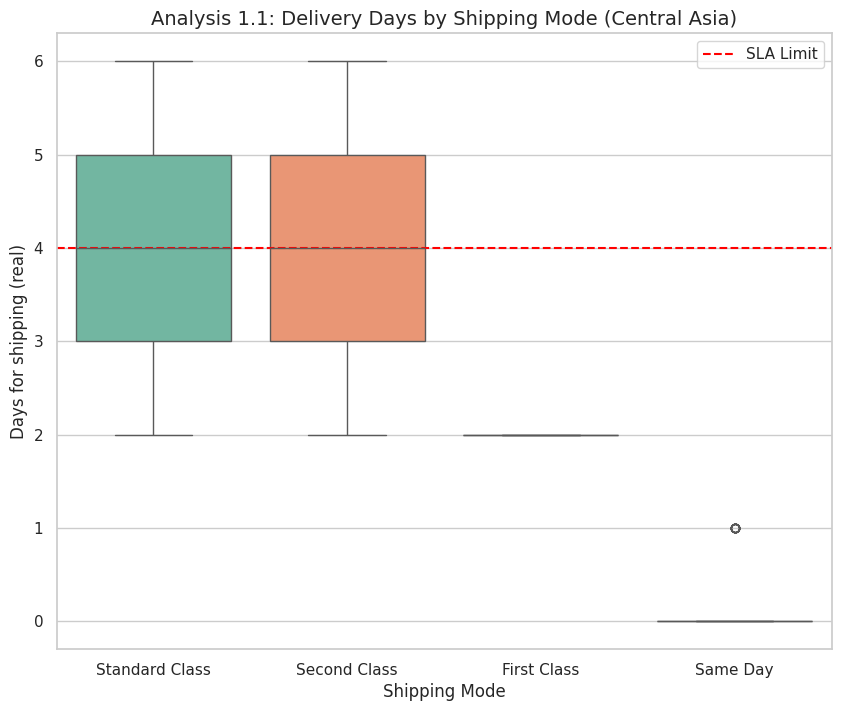

In [ ]:
# --- Analysis 1.1: Delivery Days by Shipping Mode (Central Asia) ---

plt.figure(figsize=(10, 8))

# Using the boxplot to visualize real shipping days across modes
# This specifically proves the "First Class Systemic Failure"
sns.boxplot(x='Shipping Mode', y='Days for shipping (real)', data=df_central_asia,
            order=['Standard Class', 'Second Class', 'First Class', 'Same Day'],
            palette='Set2', hue='Shipping Mode', legend=False)

# Adding the red dashed line for the SLA Limit as seen in your screenshot
plt.axhline(y=4, color='red', linestyle='--', label='SLA Limit')

plt.title('Analysis 1.1: Delivery Days by Shipping Mode (Central Asia)', fontsize=14)
plt.ylabel('Days for shipping (real)')
plt.legend()
plt.show()

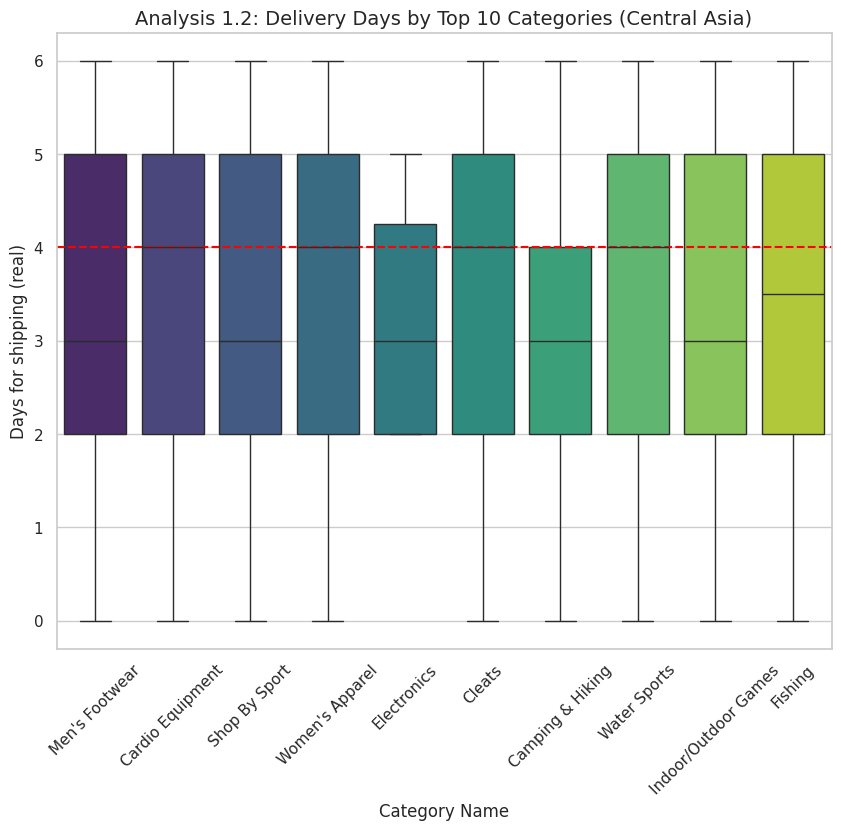

In [ ]:

# --- Analysis 1.2: Delivery Days by Top 10 Categories (Central Asia) ---

# 1. Identify the Top 10 categories by order volume
top_10_categories = df_central_asia['Category Name'].value_counts().nlargest(10).index

# 2. Filter the dataframe for these top 10 categories
df_top_10 = df_central_asia[df_central_asia['Category Name'].isin(top_10_categories)]

plt.figure(figsize=(10, 8))

# Create the boxplot for categories as shown in your image
sns.boxplot(x='Category Name', y='Days for shipping (real)', data=df_top_10,
            palette='viridis', hue='Category Name', legend=False)

# Adding the red dashed line for the SLA Limit
plt.axhline(y=4, color='red', linestyle='--', label='SLA Limit')

plt.title('Analysis 1.2: Delivery Days by Top 10 Categories (Central Asia)', fontsize=14)
plt.xticks(rotation=45) # Rotating labels for better readability
plt.ylabel('Days for shipping (real)')
plt.show()

## Segment 2: Identifying Underperforming Hubs (Pareto & Correlation)
- **Pareto Principle:** Focused on "The Vital Few" states with >= 23 orders.
- **Correlation Result:** $r = -0.157$.
- **Conclusion:** The negative and near-zero correlation proves that increasing volume does not lead to higher late rates, pointing to process failure rather than capacity issues, which **debunks** the Capacity Overload hypothesis
- **Hotspots:** Ciudad de Almatý and Asjabad are critical outliers.

Pearson Correlation (r): 0.1617


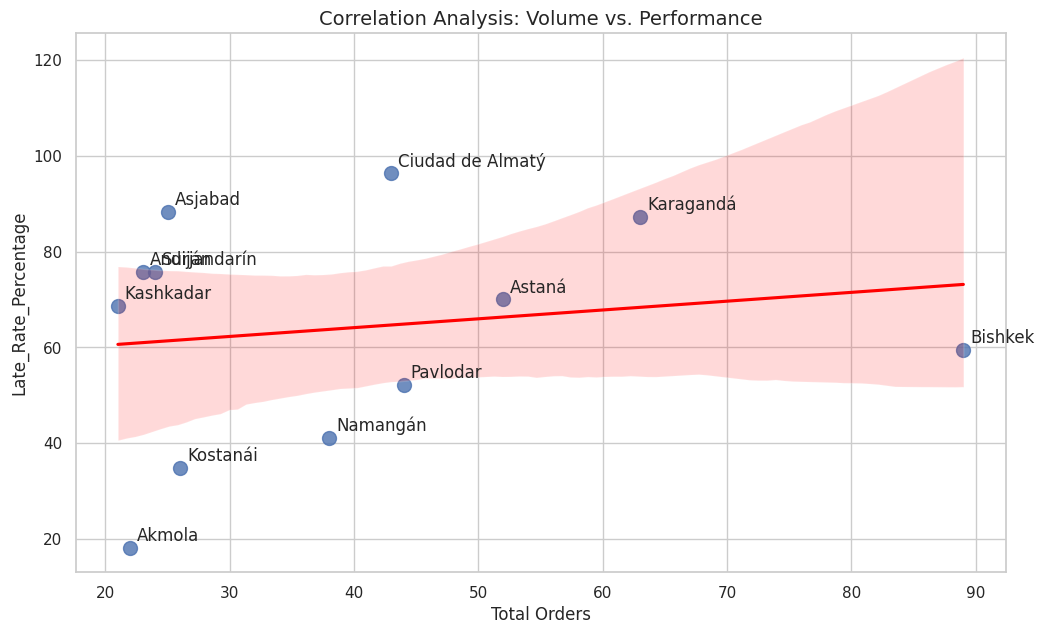

In [ ]:
# --- STEP 2: Correlation Analysis ---

# Calculate Pearson Correlation coefficient (r)
# Hypothesis: If r is high (>0.6), delays are caused by Capacity Overload.
# If r is near 0, delays are caused by Operational Inefficiency.
corr_value = key_states_performance['Total Orders'].corr(key_states_performance['Late_Rate_Percentage'])
print(f"Pearson Correlation (r): {corr_value:.4f}")

# Visualization: Scatter Plot with Regression Line
plt.figure(figsize=(12, 7))
sns.regplot(x='Total Orders', y='Late_Rate_Percentage', data=key_states_performance,
            scatter_kws={'s':100}, line_kws={'color':'red'})

# Labeling states to identify outliers (e.g., Ciudad de Almaty)
for i, txt in enumerate(key_states_performance['Order State']):
    plt.annotate(txt, (key_states_performance['Total Orders'].iat[i],
                       key_states_performance['Late_Rate_Percentage'].iat[i]),
                 xytext=(5, 5), textcoords='offset points')

plt.title('Correlation Analysis: Volume vs. Performance', fontsize=14)
plt.show()

## Segment 3: Time-Series & Seasonality Trends

>**Analysis Note:**
>* **Year-End Surge:** The late delivery rate escalates from October (51%) to a peak in December (75%).
>* **Scalability Gap:** The logistics network lacks the "elasticity" to handle Q4 surges. While the core issue is operational (identified in Segment 2), these flaws are catastrophically magnified during seasonal peaks.
>* **Statistical Anomaly (August 2016):** While the data shows a 100% late rate for August 2016, this is identified as a statistical outlier. This month contained only a single order and should be disregarded.

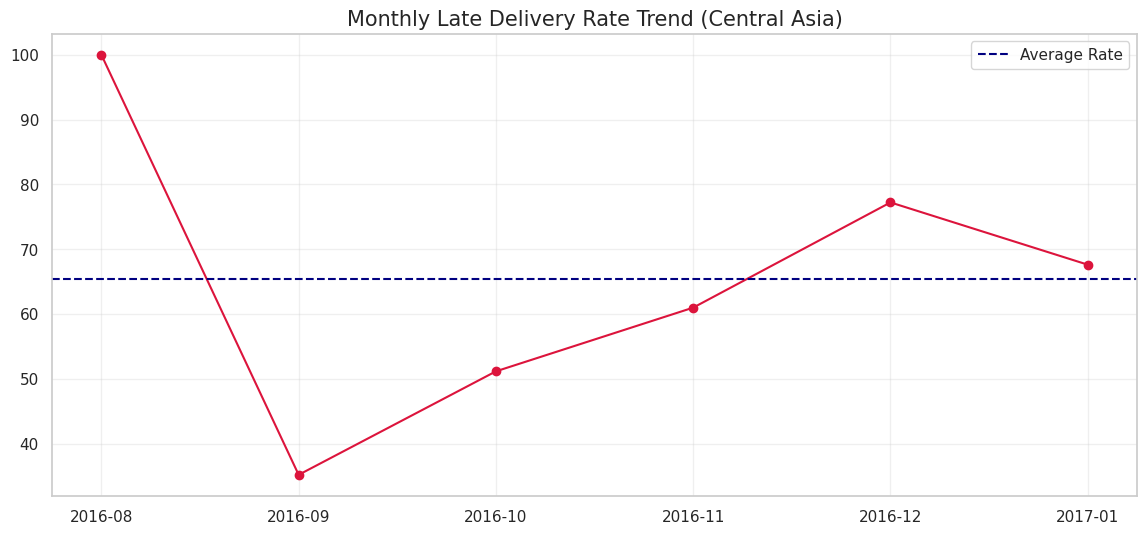

In [ ]:
# --- STEP 3: Temporal Trend Analysis ---

# Add column Order Month by extracting Year and Month from Date Orders column
df_central_asia['Order_Month'] = df_central_asia['Date Orders'].dt.to_period('M')

# Calculate monthly Late Delivery Rate
monthly_trend = df_central_asia.groupby('Order_Month').agg(
    Total_Orders=('Late Delivery', 'count'),
    Late_Orders=('Late Delivery', 'sum')
).reset_index()

monthly_trend['Late_Rate'] = (monthly_trend['Late_Orders'] / monthly_trend['Total_Orders']) * 100
monthly_trend['Order_Month'] = monthly_trend['Order_Month'].astype(str)

# Plotting the Trendline
plt.figure(figsize=(14, 6))
plt.plot(monthly_trend['Order_Month'], monthly_trend['Late_Rate'], marker='o', color='crimson')
plt.axhline(monthly_trend['Late_Rate'].mean(), color='navy', linestyle='--', label='Average Rate')
plt.title('Monthly Late Delivery Rate Trend (Central Asia)', fontsize=15)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

##4. Strategic Business Recommendations
Based on the data-driven evidence from this diagnostic, I propose three strategic pillars to optimize logistics performance in the Central Asia region:

### A. Operational Overhaul for Premium Services (First Class)
- **The Issue:** A 100% SLA failure rate in First Class shipments indicates that "Express" is currently only a label, not a reality.

- **Action Plan:**
  * Implement a "Fast-Track Lane" in regional sorting centers specifically for First Class orders to ensure processing time stays under 24 hours.
  * Re-negotiate contracts with Last-Mile partners in Central Asia, as the data shows no significant lead-time differentiation between shipping tiers.

### B. Resource Allocation & Demand Smoothing
- **The Issue:** Evidence of "Over-servicing" in Standard Class (arriving faster than required) suggests misallocated operational bandwidth.

- **Action Plan:**
  * De-prioritize Standard Class during high-volume periods to free up capacity for premium-tier orders.
  * Introduce dynamic shipping windows on the storefront that reflect real-time regional capacity to manage customer expectations.

### C. Peak Season Scalability (Q4 Management)
- **The Issue:** Late rates surge to 75% in December, proving the current system cannot scale with seasonal demand.

- **Action Plan:**
  * Labor Scaling: Increase temporary staffing in the "Vital Few" states (identified via Pareto analysis) starting from early November.
  * Proactive Buffering: Move inventory closer to high-volume Central Asian hubs (identified in Segment 2) before the December peak to minimize transit legs.

# 🛠️ Technical Appendix (Technical Reference)

### A. Data Schema Summary
This analysis utilizes the `df_central_asia` subset containing 553 entries and 11 key columns.
- **Primary Keys:** `Order City`, `Order State`.
- **Target Variable:** `Late Delivery` (Binary: 1 for Late, 0 for On-time).
- **Time Variable:** `Date Orders` (Standardized to datetime64).

### B. Statistical Methodology
- **Pareto Principle (80/20):** Applied to isolate the "Vital Few" states. States with < 23 orders were excluded to reduce statistical noise.
- **Correlation Analysis:** Used Pearson’s r to evaluate the relationship between 'Total Orders' and 'Late Rate'.
- **Result:** $r \approx -0.15$ (Indicating no significant relationship between volume and delays).

### C. Environment & Libraries Used
- **Computing Environment:** The analysis was developed and executed on Google Colab using the Python 3 runtime.
- **Core Libraries:**
  * Pandas: The primary engine for data manipulation, including filtering 53 columns down to 10, datetime conversion, and multi-level aggregations.
  * Seaborn & Matplotlib: Used to generate all diagnostic visualizations, such as SLA-limit boxplots, correlation scatter plots, and time-series trendlines.